In [1]:
import pickle
import os
from openeye import oechem
###########################################
# IMPORTS
###########################################
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from simtk import unit, openmm
from perses.tests.utils import compute_potential_components
from openmmtools.constants import kB
from perses.dispersed.utils import configure_platform
from perses.annihilation.rest import RESTTopologyFactory, RESTTopologyFactoryV3
from perses.annihilation.lambda_protocol import RESTState, RESTStateV3
import numpy as np
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys
from openmmtools.testsystems import AlanineDipeptideVacuum, AlanineDipeptideExplicit
import itertools
import matplotlib.pyplot as plt

#############################################
# CONSTANTS
#############################################
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
REFERENCE_PLATFORM = openmm.Platform.getPlatformByName("CUDA")

INFO:rdkit:Enabling RDKit 2021.03.5 jupyter extensions


conducting subsequent work with the following platform: CUDA


DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-rest2v3/lib/python3.9/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.4.3
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', '_heapq', 'heapq', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', 'collection

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [2]:
def compare_energy_components(rest_system, other_system, positions, platform=REFERENCE_PLATFORM):
    """
    Get energy components of a given system
    """
    platform = configure_platform(platform)

    # Create thermodynamic state and sampler state for non-rest system
    thermostate_other = ThermodynamicState(system=other_system, temperature=temperature)

    # Create context for non-rest system
    integrator_other = openmm.VerletIntegrator(1.0*unit.femtosecond)
    context_other = thermostate_other.create_context(integrator_other)
    context_other.setPositions(positions)

    # Get energy components for non-rest system
    components_other = [component for component in compute_potential_components(context_other, beta=beta)]
    
    # Create thermodynamic state for rest_system
    thermostate_rest = ThermodynamicState(system=rest_system, temperature=temperature)

    # Create context for rest system
    integrator_rest = openmm.VerletIntegrator(1.0 * unit.femtosecond)
    context_rest = thermostate_rest.create_context(integrator_rest)
    context_rest.setPositions(positions)

    # Get energy components for rest system
    components_rest = [component for component in compute_potential_components(context_rest, beta=beta)]

    print(components_other)
    print(components_rest)
    
    # Check that bond, angle, and torsion energies match
    for other, rest in zip(components_other[:3], components_rest[:3]):
        assert np.isclose([other[1]], [rest[1]]), f"The energies do not match for the {other[0]}: {other[1]} (other system) vs. {rest[1]} (REST system)"

    # Check that nonbonded energies match
    nonbonded_other = np.array([component[1] for component in components_other[3:]]).sum()
    nonbonded_rest = np.array([component[1] for component in components_rest[3:]]).sum()
    assert np.isclose([nonbonded_other], [nonbonded_rest]), f"The energies do not match for the NonbondedForce: {nonbonded_other} (other system) vs. {nonbonded_rest} (REST system)"

    print(nonbonded_other)
    print(nonbonded_rest)
    print("Energy bookkeeping was a success!")


# Test endstate validation (energy bookkeeping) for production systems

In [7]:
# Load r-htf for N501Y
with open("T42A_complex_0.pickle", "rb") as f:
    htf = pickle.load(f)
    

In [8]:
htf.hybrid_system.getForces()


[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2affc9fa4900> >,
 <openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2affdfe82810> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2b00027db4e0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2b00027db570> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b00027db600> >]

In [9]:
# Get unmodified hybrid system
positions = htf.hybrid_positions
system = htf.hybrid_system
system.removeForce(0)
# system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)



In [12]:
# Create REST-ified hybrid system
for res in htf.hybrid_topology.residues:
    if res.resSeq == 83 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
factory = RESTTopologyFactoryV3(system, htf.hybrid_topology, rest_region=query_indices, use_dispersion_correction=True)
REST_system = factory.REST_system

INFO:REST:*** Generating RESTTopologyFactoryV3 ***
INFO:REST:No unknown forces.
INFO:REST:alpha_ewald is 2.7569734238004693
INFO:REST:No MonteCarloBarostat added.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.7997, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.7997, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.7997), unit=nanometer)]


In [13]:
REST_system.getForces()

[<openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2afff3a492d0> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2afff3a49090> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2afff3a494e0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2afff3a495a0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2afff3a494b0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2afff3a498d0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2afff3a49cc0> >]

In [16]:
compare_energy_components(REST_system, system, positions)


conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 190.422816373736), ('HarmonicAngleForce', 985.4863168499243), ('PeriodicTorsionForce', 3830.525428648827), ('NonbondedForce', 1009543.8919122608), ('AndersenThermostat', 0.0)]
[('CustomBondForce', 190.422816373736), ('CustomAngleForce', 985.4863168499243), ('CustomTorsionForce', 3830.525597734782), ('CustomNonbondedForce', -144729.3946850595), ('CustomNonbondedForce', 1164850.2942324295), ('CustomBondForce', 809622.4274020933), ('NonbondedForce', -820199.4379289018), ('AndersenThermostat', 0.0)]
1009543.8919122608
1009543.8890205615
Energy bookkeeping was a success!


# Test energy validation for rest vs alchemical system

In [46]:
# Load htf for N501Y
with open("/data/chodera/zhangi/perses_benchmark/neq/20/30/30_apo.pickle", "rb") as f:
    htf = pickle.load(f)
    other_system = htf.hybrid_system
    

In [47]:
# Load r-htf for N501Y
with open("/data/chodera/zhangi/perses_benchmark/neq/20/30/30_apo_0.pickle", "rb") as f:
    rhtf = pickle.load(f)
    

In [83]:
# Read in REST snapshot
with open("/data/chodera/zhangi/perses_benchmark/neq/20/30/30_apo_arg_1ns_snapshots.npy", "rb") as f:
    cache = np.load(f)
    positions = cache[0]

In [24]:
htf.hybrid_system.getForces()


[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2ac1bf123db0> >,
 <simtk.openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2ac1bf1236c0> >,
 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2ac1bf1238d0> >,
 <simtk.openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2ac1bf123ea0> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2ac1bc373510> >,
 <simtk.openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2ac1bc373450> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2ac1bc373ed0> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ac1bc3733f0> >,
 <simtk.openmm.o

In [25]:
htf.hybrid_system.getForce(7).getUseDispersionCorrection()

True

In [26]:
htf.hybrid_system.getForce(8).getUseLongRangeCorrection()

False

In [62]:
htf.hybrid_system.getForce(8).setUseLongRangeCorrection(True)

In [60]:
rhtf.hybrid_system.getForces()

[<simtk.openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2ac1b49fd510> >,
 <simtk.openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x2ac1b49fd690> >,
 <simtk.openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x2ac1b49fd9f0> >,
 <simtk.openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x2ac1b49fd660> >,
 <simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ac1b49fd930> >]

In [61]:
rhtf.hybrid_system.getForce(4).getUseDispersionCorrection()

True

In [63]:
platform = configure_platform(REFERENCE_PLATFORM)

# Create thermodynamic state and sampler state for non-rest system
thermostate_other = ThermodynamicState(system=other_system, temperature=temperature)

# Create context for non-rest system
integrator_other = openmm.VerletIntegrator(1.0*unit.femtosecond)
context_other = thermostate_other.create_context(integrator_other)
context_other.setPositions(positions)

# Get energy components for non-rest system
components_other = [component[1] for component in compute_potential_components(context_other, beta=beta)]
print(compute_potential_components(context_other, beta=beta))


conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 13.699962314812757), ('HarmonicBondForce', 517.3075394557935), ('CustomAngleForce', 30.368232433776903), ('HarmonicAngleForce', 1340.4011976952545), ('CustomTorsionForce', 5.3660797531597755), ('PeriodicTorsionForce', 2233.937375370346), ('NonbondedForce', -122936.57998551511), ('CustomNonbondedForce', -69.98328336984765), ('CustomBondForce', -507.6435468959307), ('AndersenThermostat', 0.0), ('MonteCarloBarostat', 0.0)]


In [81]:
# Create REST-ified hybrid system
for res in htf.hybrid_topology.residues:
    if res.resSeq == 83 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
factory = RESTTopologyFactoryV2(rhtf.hybrid_system, rhtf.hybrid_topology, rest_region=query_indices, use_dispersion_correction=True)
REST_system = factory.REST_system
# REST_system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
# REST_system.getForce(4).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)


INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.2004, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.2004, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.2004), unit=nanometer)]
INFO:REST:No unknown forces.
INFO:REST:Handling constraints
INFO:REST:Handling bonds
INFO:REST:Handling angles
INFO:REST:Handling torsions
INFO:REST:Handling nonbondeds
INFO:REST:Handling nonbonded scaling (custom nb)
INFO:REST:Handling nonbonded exception scaling (custom bond)


In [84]:
# Create thermodynamic state for rest_system
thermostate_rest = ThermodynamicState(system=REST_system, temperature=temperature)

# Create context for rest system
integrator_rest = openmm.VerletIntegrator(1.0 * unit.femtosecond)
context_rest = thermostate_rest.create_context(integrator_rest)
context_rest.setPositions(positions)

# Get energy components for rest system
components_rest = [component[1] for component in compute_potential_components(context_rest, beta=beta)]
print(compute_potential_components(context_rest, beta=beta))

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 531.0075017706062), ('CustomAngleForce', 1370.7694301290317), ('CustomTorsionForce', 2239.303907964772), ('NonbondedForce', -123514.20672016767), ('CustomNonbondedForce', 0.0), ('CustomBondForce', 0.0), ('AndersenThermostat', 0.0), ('MonteCarloBarostat', 0.0)]


In [85]:
assert np.isclose([components_other[0] + components_other[1]], [components_rest[0]])


In [86]:
assert np.isclose([components_other[2] + components_other[3]], [components_rest[1]])


In [87]:
assert np.isclose([components_other[4] + components_other[5]], [components_rest[2]])


In [88]:
assert np.isclose(components_other[6] + components_other[7] + components_other[8], components_rest[3] + components_rest[4] + components_rest[5]), f"The energies do not match for the {components_other[6] + components_other[7] + components_other[8]} (other system) vs. {components_rest[3]} (REST system)"


In [89]:
components_rest

[531.0075017706062,
 1370.7694301290317,
 2239.303907964772,
 -123514.20672016784,
 0.0,
 0.0,
 0.0,
 0.0]

In [90]:
components_other

[13.699962314812757,
 517.3075394557935,
 30.368232433776903,
 1340.4011976952545,
 5.3660797531597755,
 2233.937375370346,
 -122936.57998551511,
 -69.98328336984765,
 -507.6435468959307,
 0.0,
 0.0]

In [91]:
components_other[6] + components_other[7] + components_other[8]


-123514.20681578088

In [92]:
components_rest[3] + components_rest[4] + components_rest[5]


-123514.20672016784

### Run 100 ps of MD on unscaled system and check energies of alchemical hybrid system vs rest system at 300 K

In [93]:
import openmmtools
from openmmtools import cache
from tqdm import tqdm_notebook
from perses.dispersed import feptasks


In [94]:
phase = 'apo'
name = "arg"
state = 0

length = 1
move_length = 1
timestep = 4
radius = 0.4

outdir = "/data/chodera/zhangi/perses_benchmark/neq/20/30/"

In [95]:
# Load rhtf
i = os.path.basename(os.path.dirname(outdir))
path = os.path.join(outdir, f"{i}_{phase}_0.pickle")
htf = pickle.load(open(path, "rb" ))

    

In [96]:
thermostate = ThermodynamicState(htf.hybrid_system, temperature=300 *unit.kelvin)
sampler_state = SamplerState(htf.hybrid_positions, box_vectors=htf.hybrid_system.getDefaultPeriodicBoxVectors())

In [97]:
context_cache = cache.global_context_cache
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                              collision_rate=1 / unit.picoseconds,
                                              timestep= 4 * unit.femtoseconds)

In [98]:
context, integrator = context_cache.get_context(thermostate, integrator)
sampler_state.apply_to_context(context)

In [99]:
openmm.LocalEnergyMinimizer.minimize(context)

In [100]:
positions = list()
for _ in tqdm_notebook(range(int(25000/250))):
    integrator.step(250)
    
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    positions.append(pos)

<ipython-input-100-2cac9fbaae0a>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(25000/250))):


  0%|          | 0/100 [00:00<?, ?it/s]

In [124]:
# Read in REST snapshot
with open("/data/chodera/zhangi/perses_benchmark/neq/20/30/30_apo_arg_1ns_snapshots.npy", "rb") as f:
    snapshot_cache = np.load(f)


In [121]:
positions

[Quantity(value=array([[1.62017547, 5.11637411, 2.7475182 ],
        [1.66982637, 5.04084127, 2.63176454],
        [1.67142078, 5.09295431, 2.52177737],
        ...,
        [5.00493253, 1.41303123, 4.0767216 ],
        [5.64715911, 0.7793285 , 1.6171197 ],
        [2.96300286, 4.11161913, 1.60323354]]), unit=nanometer),
 Quantity(value=array([[1.62449643, 5.17777502, 2.65802698],
        [1.69007451, 5.0857864 , 2.56030339],
        [1.70973636, 5.12088494, 2.44227357],
        ...,
        [4.94859993, 1.38447439, 4.06003112],
        [5.65277843, 0.74474344, 1.60646749],
        [2.97459435, 4.07452748, 1.59800201]]), unit=nanometer),
 Quantity(value=array([[1.5107626 , 5.00397512, 2.78941195],
        [1.58431074, 4.97083754, 2.66117482],
        [1.55226889, 5.03471042, 2.56287271],
        ...,
        [4.86198711, 1.35227954, 3.92806891],
        [5.66197603, 0.68776609, 1.66034594],
        [3.05681162, 4.0529194 , 1.52252507]]), unit=nanometer),
 Quantity(value=array([[1.69912

In [136]:
platform = configure_platform(REFERENCE_PLATFORM)
# Create thermodynamic state and sampler state for non-rest system
thermostate_other = ThermodynamicState(system=other_system, temperature=temperature)

# Create context for non-rest system
integrator_other = openmm.VerletIntegrator(1.0*unit.femtosecond)
context_other = thermostate_other.create_context(integrator_other)
    
energies_other = []
for position in positions:
    
    # Set positions
    context_other.setPositions(position)
    sampler_state = SamplerState.from_context(context_other)
    
    # Get energy
    energy = thermostate_other.reduced_potential(sampler_state)
    energies_other.append(energy)

conducting subsequent work with the following platform: CPU


In [137]:
# Create thermodynamic state for rest_system
thermostate_rest = ThermodynamicState(system=REST_system, temperature=temperature)

# Create context for rest system
integrator_rest = openmm.VerletIntegrator(1.0 * unit.femtosecond)
context_rest = thermostate_rest.create_context(integrator_rest)

energies_rest = []
for position in positions:
    
    # Set positions
    context_rest.setPositions(position)
    sampler_state = SamplerState.from_context(context_rest)
    
    # Get energy
    energy = thermostate_rest.reduced_potential(sampler_state)
    energies_rest.append(energy)

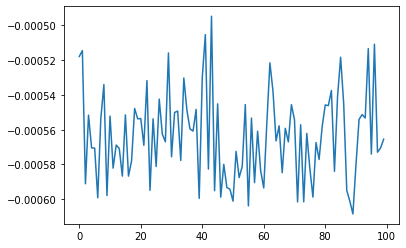

In [138]:
plt.plot(np.array(energies_other) - np.array(energies_rest))
plt.show()

# Run energy scaling test v2 on scaled rest bnbs system

In [3]:
import copy
from tqdm import tqdm_notebook
import mdtraj as md
###########################################
# IMPORTS
###########################################
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from simtk import unit, openmm
from perses.tests.utils import compute_potential_components
from openmmtools.constants import kB
from perses.dispersed.utils import configure_platform
from perses.annihilation.rest import RESTTopologyFactoryV3
from perses.annihilation.lambda_protocol import RESTStateV3
import numpy as np
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys
from openmmtools.testsystems import AlanineDipeptideVacuum, AlanineDipeptideExplicit
import itertools

#############################################
# CONSTANTS
#############################################
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
REFERENCE_PLATFORM = openmm.Platform.getPlatformByName("Reference")



In [4]:
def compare_energies(topology, REST_system, other_system, positions, rest_atoms, T_min, T):
    print("prepping systems")
    # Remove standard NonbondedForce (which contains reciprocal space) from REST_system
    REST_system.removeForce(6)

    # Prevent reciprocal space from being used in the original system energy
    other_system.getForce(3).setReciprocalSpaceForceGroup(31)    
    
    print("creating rest thermostate and setting alchemical params")
    # Create thermodynamic state
    lambda_zero_alchemical_state = RESTStateV3.from_system(REST_system)
    thermostate = ThermodynamicState(REST_system, temperature=T_min)
    compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                              composable_states=[lambda_zero_alchemical_state])
    
    # Set alchemical parameters
    beta_0 = 1 / (kB * T_min)
    beta_m = 1 / (kB * T)
    compound_thermodynamic_state.set_alchemical_parameters(beta_0, beta_m)
    
    print("getting rest system energy")
    # Get energy
    integrator = openmm.VerletIntegrator(1.0 * unit.femtosecond)
    context = compound_thermodynamic_state.create_context(integrator)
    context.setPositions(positions)
    REST_energy = context.getState(getEnergy=True).getPotentialEnergy().value_in_unit_system(unit.md_unit_system)
    
    print("getting solvent atoms")
    # Get solvent atoms
    positive_ion_name = "NA"
    negative_ion_name = "CL"
    water_name = "HOH"
    solvent_atoms = []
    if 'openmm' in topology.__module__:
        atoms = topology.atoms()
    elif 'mdtraj' in topology.__module__:
        atoms = topology.atoms
    for atom in atoms:
        if atom.residue.name == positive_ion_name or atom.residue.name == negative_ion_name or atom.residue.name == water_name:
            solvent_atoms.append(atom.index)
    
    # Compute energy for non-RESTified system
    # Determine regions and scaling factors
    nonrest_atoms = [i for i in range(other_system.getNumParticles()) if i not in rest_atoms]
    rest_scaling = beta_m / beta_0
    inter_scaling = np.sqrt(beta_m / beta_0)
    
    # Compute 3 energies: 
    ## Test case 0: rest-rest energy
    ## Test case 1: nonrest-nonrest energy
    ## Test case 2: total energy
    ## Test case 3: nonrest_solvent - rest (this will only be a nonbonded energy)
    ## Test case 4: nonrest_solvent - nonrest-solvent (this will only be a nonbonded energy)
    ## Test case 5: rest-rest nonbonded energy
    unmodified_energies = []
    for test_case in range(6):
        print("running test case: ", test_case)
        system_copy = copy.deepcopy(other_system)
        
        if test_case != 2:
            bond_force = system_copy.getForce(0)
            for bond_index in range(bond_force.getNumBonds()):
                p1, p2, length, k = bond_force.getBondParameters(bond_index)
                particles = [p1, p2]
                if all(x in rest_atoms for x in particles):
                    if test_case in [1, 3, 4, 5]:
                        bond_force.setBondParameters(bond_index, p1, p2, length, k*0)
                    else:
                        continue
                elif all(x in nonrest_atoms for x in particles):
                    if test_case in [0, 3, 4, 5]:
                        bond_force.setBondParameters(bond_index, p1, p2, length, k*0)
                    else:
                        continue
                else:
                    bond_force.setBondParameters(bond_index, p1, p2, length, k*0)

            angle_force = system_copy.getForce(1)
            for angle_index in range(angle_force.getNumAngles()):
                p1, p2, p3, angle, k = angle_force.getAngleParameters(angle_index)
                particles = [p1, p2, p3]
                if all(x in rest_atoms for x in particles):
                    if test_case in [1, 3, 4, 5]:
                        angle_force.setAngleParameters(angle_index, p1, p2, p3, angle, k*0) 
                    else:
                        continue
                elif all(x in nonrest_atoms for x in particles):
                    if test_case in [0, 3, 4, 5]:
                        angle_force.setAngleParameters(angle_index, p1, p2, p3, angle, k*0) 
                    else:
                        continue
                else:
                    angle_force.setAngleParameters(angle_index, p1, p2, p3, angle, k*0) 

            torsion_force = system_copy.getForce(2)
            for torsion_index in range(torsion_force.getNumTorsions()):
                p1, p2, p3, p4, periodicity, phase, k = torsion_force.getTorsionParameters(torsion_index)
                particles = [p1, p2, p3, p4]
                if all(x in rest_atoms for x in particles):
                    if test_case in [1, 3, 4, 5]:
                        torsion_force.setTorsionParameters(torsion_index, p1, p2, p3, p4, periodicity, phase, k*0)
                    else:
                        continue
                elif all(x in nonrest_atoms for x in particles):
                    if test_case in [0, 3, 4, 5]:
                        torsion_force.setTorsionParameters(torsion_index, p1, p2, p3, p4, periodicity, phase, k*0)
                    else:
                        continue
                else:
                    torsion_force.setTorsionParameters(torsion_index, p1, p2, p3, p4, periodicity, phase, k*0)

            nb_force = system_copy.getForce(3)
            for i in range(nb_force.getNumExceptions()):
                p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
                particles = [p1, p2]
                if all(x in rest_atoms for x in particles):
                    if test_case in [1, 4]:
                        nb_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)
                    else:
                        continue
                elif all(x in nonrest_atoms for x in particles):
                    if test_case in [0, 5]:
                        nb_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)
                    elif test_case in [3, 4]:
                        if all(x in solvent_atoms for x in particles):
                            continue
                        else:
                            nb_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)
                    else:
                        continue
                else:
                    if test_case == 3:
                        if any(x in solvent_atoms for x in particles):
                            continue
                        else:
                            nb_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)
                    else:
                        nb_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)

            for i in range(nb_force.getNumParticles()):
                charge, sigma, epsilon = nb_force.getParticleParameters(i)
                if i in rest_atoms:
                    if test_case in [1, 4]:
                        nb_force.setParticleParameters(i, charge*0, sigma, epsilon*0)
                    else:
                        continue
                else:
                    if test_case in [0, 5]:
                        nb_force.setParticleParameters(i, charge*0, sigma, epsilon*0)
                        
                    elif test_case in [3, 4]:
                        if i in solvent_atoms:
                            continue
                        else:
                            nb_force.setParticleParameters(i, charge*0, sigma, epsilon*0)
                            
                    else:
                        continue     
        
        
        # Get energy
        thermostate = ThermodynamicState(system_copy, temperature=T_min)
        integrator = openmm.VerletIntegrator(1.0 * unit.femtosecond)
        context = thermostate.create_context(integrator)
        context.setPositions(positions)
        system_copy_energy = context.getState(getEnergy=True, groups=set([0])).getPotentialEnergy().value_in_unit_system(unit.md_unit_system)
        unmodified_energies.append(system_copy_energy)
    
    print("computing final unmodified system energy")
    print(unmodified_energies)
    nonrest_solvent_rest = unmodified_energies[3] - unmodified_energies[5] - unmodified_energies[4]
    nonrest_protein_rest = unmodified_energies[2] - unmodified_energies[0] - unmodified_energies[1] - nonrest_solvent_rest
    unmodified_energy = unmodified_energies[0] * rest_scaling + unmodified_energies[1] +  nonrest_solvent_rest * rest_scaling + nonrest_protein_rest * inter_scaling
    print(unmodified_energy)
    print(REST_energy)
#     assert np.isclose(REST_energy, unmodified_energy), f"REST energy was {REST_energy} and unmodified_energy was {unmodified_energy}"
                            

In [5]:
# Load r-htf for N501Y
with open("T42A_complex_0.pickle", "rb") as f:
    htf = pickle.load(f)
    

In [6]:
# Get unmodified hybrid system
positions = htf.hybrid_positions
system = htf.hybrid_system
system.removeForce(0)



In [7]:
# Build REST factory
for res in htf.hybrid_topology.residues:
    if res.resSeq == 83 and res.chain.index == 0:
        mutated_res = res
query_indices = [atom.index for atom in mutated_res.atoms]
traj = md.Trajectory(np.array(htf.hybrid_positions), htf.hybrid_topology)
solute_atoms = list(traj.topology.select("is_protein"))
radius = 0.3
rest_atoms = list(md.compute_neighbors(traj, radius, query_indices, haystack_indices=solute_atoms)[0])
rest_atoms = [int(atom) for atom in rest_atoms]
factory = RESTTopologyFactoryV3(htf.hybrid_system, htf.hybrid_topology, rest_region=rest_atoms, use_dispersion_correction=True)

INFO:REST:*** Generating RESTTopologyFactoryV3 ***
INFO:REST:No unknown forces.
INFO:REST:alpha_ewald is 2.7569734238004693
INFO:REST:No MonteCarloBarostat added.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=6.7997, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=6.7997, z=0.0), unit=nanometer), Quantity(value=Vec3(x=0.0, y=0.0, z=6.7997), unit=nanometer)]


In [8]:
T_min = 300.0 * unit.kelvin
T = 600 * unit.kelvin
compare_energies(htf.hybrid_topology, factory.REST_system, system, positions, rest_atoms, T_min, T)

prepping systems
creating rest thermostate and setting alchemical params
getting rest system energy
getting solvent atoms
running test case:  0
running test case:  1
running test case:  2
running test case:  3
running test case:  4
running test case:  5
computing final unmodified system energy
[686.6416437321452, 4575578.550905871, 4576500.708689945, 1874748.046089118, 1874171.4281917647, 612.8222262508641]
4576095.904949675
4576095.823836652
